# Training

In this notebook two neural networks are trained:
- a reference network using a squared error loss function
- a quantile regression neural network (QRNN)

## The Data


In [3]:
import utils.config
import numpy as np
import matplotlib.pyplot as plt
%env KERAS_BACKEND=tensorflow

x_train     = np.load("data/x_train.npy")
y_train     = np.load("data/y_train.npy")
x_val       = np.load("data/x_val.npy")
y_val       = np.load("data/y_val.npy")
cloud_types = np.load("data/cloud_types_train.npy")

env: KERAS_BACKEND=tensorflow


/home/simon/src/matplotlib/lib/matplotlib/axes/_axes.py:6177: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0,0,'Low'), Text(0,0,'Medium'), Text(0,0,'High')]

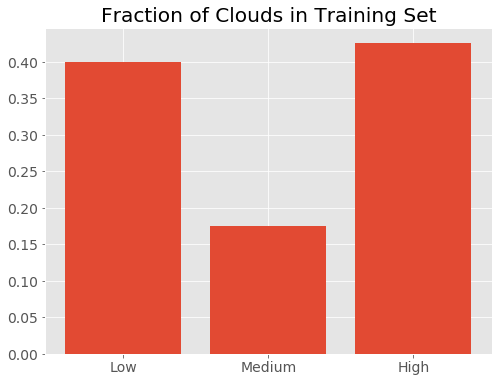

In [4]:
bins = np.array([-0.5, 0.5, 1.5, 2.5])
plt.hist(cloud_types, bins = bins, normed = True, rwidth = 0.8)
plt.title("Fraction of Clouds in Training Set")
plt.xticks([0, 1, 2])
plt.gca().xaxis.set_ticklabels(["Low", "Medium", "High"])

/home/simon/src/matplotlib/lib/matplotlib/axes/_axes.py:6177: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Normalized Frequency')

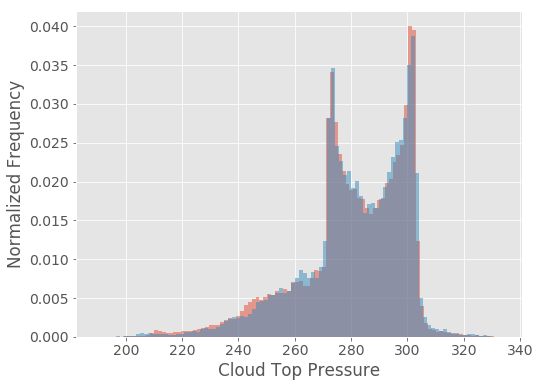

In [5]:
x_val = np.load("data/x_val.npy")
i = 1
plt.hist(x_train[:, i], normed = True, alpha = 0.5, bins = 101)
#plt.hist(y_val,  normed = True, alpha = 0.5, bins = 51)
plt.hist(x_val[:, i],  normed = True, alpha = 0.5, bins = 101)
plt.xlabel("Cloud Top Pressure")
plt.ylabel("Normalized Frequency")

## Training

In [6]:
adversarial_training = True
delta_at             = 0.05
ensemble_size        = 5
depth                = 4
width                = 64

filename = "models/qrnn_"
filename += str(depth) + "_" + str(width) + "_ensemble_" + str(ensemble_size)
if adversarial_training:
    filename += "_at_" + str(int(delta_at * 100))
filename    

'models/qrnn_4_64_ensemble_5_at_5'

In [ ]:
from typhon.retrieval.qrnn import QRNN

n_input = x_train.shape[1]
quantiles = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])


adversarial_training = True
delta_at             = 0.05
ensemble_size        = 5
depth                = 4
width                = 64

filename = "models/qrnn_"
filename += str(depth) + "_" + str(width) + "_ensemble_" + str(ensemble_size)
if adversarial_training:
    filename += "_at_" + str(int(delta_at * 100))

qrnn_simple = QRNN(n_input, quantiles, depth = depth, width = width, ensemble_size = ensemble_size)
qrnn_simple.fit(x_train, y_train.reshape(-1, 1), sigma_noise = None,
                adversarial_training = adversarial_training,
                delta_at = delta_at,
                x_val = x_val,
                y_val = y_val,
                initial_learning_rate = 0.001,
                batch_size = 128,
                learning_rate_minimum = 1e-4,
                learning_rate_decay = 2,
                maximum_epochs = 500,
                convergence_epochs = 0)
qrnn_simple.save(filename)

Epoch 1/500
26672/26672 [==============================] - 92s 3ms/step - loss: 527.6757 - val_loss: 383.9153
Epoch 2/500
26666/26672 [============================>.] - ETA: 0s - loss: 494.9579
 Reduced learning rate to 0.001
26672/26672 [==============================] - 90s 3ms/step - loss: 494.9649 - val_loss: 443.2393
Epoch 3/500
26670/26672 [============================>.] - ETA: 0s - loss: 437.5083
 Reduced learning rate to 0.0005
26672/26672 [==============================] - 93s 3ms/step - loss: 437.5089 - val_loss: 385.7492
Epoch 4/500
26672/26672 [==============================] - 90s 3ms/step - loss: 427.1466 - val_loss: 359.2780
Epoch 5/500
26672/26672 [==============================] - 90s 3ms/step - loss: 425.6872 - val_loss: 357.7680
Epoch 6/500
26655/26672 [============================>.] - ETA: 0s - loss: 423.7251
 Reduced learning rate to 0.00025
26672/26672 [==============================] - 98s 4ms/step - loss: 423.7335 - val_loss: 357.8588
Epoch 7/500
26672/26672 [

## The Reference Model

We also fit an identical reference model, but training with a squared error loss function.

In [ ]:
ts = 0.9
n = x_train.shape[0]
n_train = round(ts * n)
n_val = n - n_train
inds  = np.random.permutation(n)
x_val_ref = x_train[inds[n_train:], :]
y_val_ref = y_train[inds[n_train:]]
x_train_ref = x_train[inds[:n_train], :]
y_train_ref = y_train[inds[:n_train]]

In [ ]:
from keras.models import Sequential, clone_model
from keras.optimizers import SGD
from keras.layers import Dense
from keras.losses import mean_squared_error
from typhon.retrieval.qrnn.qrnn import TrainingGenerator, ValidationGenerator, LRDecay

input_dim = 16
width = 64
activation = "relu"

model = Sequential()
model.add(Dense(input_dim = input_dim,
                units = width,
                activation = activation))
model.add(Dense( units = width,
                activation = activation))
model.add(Dense( units = width,
                activation = activation))
model.add(Dense(units = 1, activation = None))

          
x_mean  = x_train.mean(axis = 0, keepdims = True)
x_sigma = x_train.std(axis = 0, keepdims = True)

model.compile(loss = mean_squared_error,
              optimizer = SGD(lr = 0.00001))
training_generator   = TrainingGenerator(x_train_ref, x_mean, x_sigma, y_train_ref, None, 1024)
validation_generator = ValidationGenerator(x_val_ref, x_mean, x_sigma, y_val_ref, None)
lr_callback = LRDecay(model, 2.0, 1e-10, 2)
model.fit_generator(training_generator, steps_per_epoch = n_train // 1024,
                   epochs = 200, validation_data = validation_generator,
                    validation_steps = 1, callbacks = [lr_callback])



Epoch 1/200
2097/2097 [==============================] - 8s - loss: 30458.9484 - val_loss: 20238.3398
Epoch 2/200
2097/2097 [==============================] - 9s - loss: 19755.7136 - val_loss: 19288.4004
Epoch 3/200
2097/2097 [==============================] - 8s - loss: 18987.4007 - val_loss: 18812.6367
Epoch 4/200
2097/2097 [==============================] - 8s - loss: 18426.1289 - val_loss: 18535.4082
Epoch 5/200
2097/2097 [==============================] - 8s - loss: 17980.5546 - val_loss: 18849.2656
Epoch 6/200
2097/2097 [==============================] - 9s - loss: 17555.0626 - val_loss: 17848.9199
Epoch 7/200
2097/2097 [==============================] - 8s - loss: 17278.7663 - val_loss: 18054.2129
Epoch 8/200
2097/2097 [==============================] - 8s - loss: 17009.1203 - val_loss: 16953.8164
Epoch 9/200
2097/2097 [==============================] - 8s - loss: 16808.0857 - val_loss: 17514.4590
Epoch 10/200
2097/2097 [==============================] - 8s - loss: 16553.5989 - 

In [ ]:
model.save("models/mse")
np.save("models/mse_mean",  x_mean)
np.save("models/mse_sigma", x_sigma)